# Analyse de donnees : Projet ECG

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import offsetbox
from pylab import *
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### Importation des données :

In [2]:
my_path = "/Users/francoisczarny/Documents/Cours_M2/analyse de donnees (B.michel)/projet ECG"
data_path_train = my_path + "/input_training.csv"
data_path_test = my_path + "/input_testing.csv"
check_res = my_path + "/training_output.csv"

A vérifier que les fichiers soient bien ceux d'entrainement et delui de test et qu'il n'y ait pas d'inversion

In [3]:
Xtrain = pd.read_csv(data_path_train, header = 0)
Xtest = pd.read_csv(data_path_test, header = 0)
Y = pd.read_csv(check_res,sep=";", header = 0)

## pour connaitre le nom des variables

In [4]:
# pour connaitre le nom des variables : 
for i in range(13):
    print(Xtrain.columns[i*750])

ID
ML1_749
ML2_749
ML3_749
AVR_749
AVL_749
AVF_749
V1_749
V2_749
V3_749
V4_749
V5_749
V6_749


In [5]:
Xtrain.head()

,ID,ML1_0,ML1_1,ML1_2,ML1_3,ML1_4,ML1_5,ML1_6,ML1_7,ML1_8,...,V6_740,V6_741,V6_742,V6_743,V6_744,V6_745,V6_746,V6_747,V6_748,V6_749
0,0.0,0.021276,0.039363,-0.001475,0.023994,0.009620,0.036350,0.028983,0.031416,0.030435,...,-0.003424,-0.007473,-0.008551,-0.011629,-0.006575,-0.006615,-0.004854,-0.005218,-0.006100,-0.006240
1,1.0,0.018403,0.026159,0.009684,0.001014,-0.000866,0.002019,0.000617,-0.011167,-0.026314,...,-0.005327,-0.002014,0.001650,0.004635,0.006291,0.006678,0.006239,0.005763,0.006071,0.007560
2,2.0,-0.020974,-0.044294,-0.044097,-0.042136,-0.041125,-0.034392,-0.033026,-0.031817,-0.032347,...,-0.068369,-0.059892,-0.055802,-0.041579,-0.033464,-0.028225,-0.026752,-0.027527,-0.029204,-0.030222
3,3.0,-0.004381,-0.017433,-0.021386,-0.020316,-0.019849,-0.023615,-0.013923,0.014080,0.088580,...,0.376336,0.357924,0.333985,0.305791,0.275263,0.244378,0.214926,0.188386,0.165124,0.144635
4,4.0,0.022106,0.065815,0.060662,0.063035,0.065413,0.064131,0.061383,0.059843,0.060229,...,-0.015729,-0.014732,-0.014419,-0.014700,-0.015416,-0.016462,-0.017845,-0.019547,-0.021242,-0.022394


In [6]:
Xtrain.iloc[:,0:3];   # pour extraire les trois premieres colonnes par exemples

In [7]:
Y.head()

,ID,TARGET
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0


### Reindexation:

On réindexe par rapport à la colonne ID

In [62]:
# suppression de ID: au moins pour les X, ne sert a rien, correspond à la ligne:
Xtrain.set_index('ID', inplace=True, drop=True);
Xtest.set_index('ID', inplace=True, drop=True);
Y.set_index('ID', inplace=True, drop=True)   # on peut peut-etre les garder pour le moment ou on va split les données
                                          # peut permettre de retrouver par la suite la ligne associé justement

vérifions que l'indexation a été faite et que la colonne ID a été supprimé:

In [9]:
print(Xtrain.columns)
Y.head(10)

Index(['ML1_0', 'ML1_1', 'ML1_2', 'ML1_3', 'ML1_4', 'ML1_5', 'ML1_6', 'ML1_7',
       'ML1_8', 'ML1_9',
       ...
       'V6_740', 'V6_741', 'V6_742', 'V6_743', 'V6_744', 'V6_745', 'V6_746',
       'V6_747', 'V6_748', 'V6_749'],
      dtype='object', length=9000)


,TARGET
ID,
0,1
1,1
2,1
3,1
4,0
5,1
6,0
7,0
8,1


vérification des dimensions des différents tableaux importés

In [5]:
print("les differentes dimension pour Xtrain, Y et Xtest: ",Xtrain.shape,Y.shape,Xtest.shape)

('les differentes dimension pour Xtrain, Y et Xtest: ', (1000, 9000), (1000, 1), (353, 9000))


In [11]:
Xtrain.dtypes;     # ne contient que des float/réels, le verifier pour les colonnes non-affichées

In [7]:
Xtrain.dtypes.unique()

array([dtype('float64')], dtype=object)

On a que des variables réelles dans le tableau.

#### Verifions que certaines colonne ne contiennent pas de NaN :

In [6]:
empty = Xtrain.apply(lambda col: pd.isnull(col))
a = [int(list(empty.ML1_1.values)[i]) for i in range(len(list(empty.ML1_1.values)))]
np.sum(a)

0

plus simple : 

In [9]:
sum(sum(pd.isnull(Xtrain))[:])

0

### separation des données sur le tableau de base Xtrain : 

In [63]:
inverted = pd.DataFrame(np.array(Xtrain)[np.where(Y["TARGET"]==1)])
no_inverted = pd.DataFrame(np.array(Xtrain)[np.where(Y["TARGET"]==0)])

 # tableau des statistiques de base sur les variables du dataframe

In [10]:
data_description = Xtrain.describe()    # On les stock pour pouvoir y accéder plus tard eventuellement
data_description;

,ML1_0,ML1_1,ML1_2,ML1_3,ML1_4,ML1_5,ML1_6,ML1_7,ML1_8,ML1_9,...,V6_740,V6_741,V6_742,V6_743,V6_744,V6_745,V6_746,V6_747,V6_748,V6_749
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.008969,0.020401,0.017880,0.018721,0.019768,0.020523,0.021309,0.022510,0.024383,0.024880,...,0.040664,0.038173,0.035667,0.034843,0.035563,0.036539,0.036646,0.037412,0.040704,0.045355
std,0.048776,0.118520,0.113965,0.123299,0.128488,0.129388,0.130624,0.128080,0.125761,0.127187,...,0.221916,0.210454,0.208374,0.214171,0.222162,0.223801,0.217808,0.223027,0.237117,0.251471
min,-0.383345,-0.887566,-1.121566,-1.159942,-1.091615,-1.417426,-1.440860,-1.214345,-0.852330,-0.837311,...,-1.926906,-1.680641,-1.434982,-1.203242,-0.992991,-0.819791,-0.753773,-1.084657,-1.331940,-1.432863
25%,-0.007694,-0.019548,-0.019586,-0.018563,-0.018279,-0.017207,-0.015761,-0.016488,-0.015960,-0.016396,...,-0.031029,-0.031520,-0.032170,-0.032805,-0.031861,-0.032344,-0.032917,-0.032717,-0.031394,-0.030158
50%,0.003244,0.008314,0.006385,0.005710,0.005888,0.006536,0.006795,0.007480,0.007107,0.007325,...,-0.001799,-0.001796,-0.001816,-0.001315,-0.001891,-0.002196,-0.001230,-0.002118,-0.001135,-0.001235
75%,0.016616,0.041505,0.042770,0.040997,0.038274,0.039169,0.039586,0.041837,0.042499,0.042226,...,0.043345,0.041935,0.040274,0.041040,0.040846,0.040559,0.042571,0.041671,0.044723,0.043275
max,0.547176,1.201830,0.760648,0.970076,0.991294,0.881598,1.042799,1.285841,1.366864,1.301137,...,1.982001,1.921432,2.240690,2.455513,2.301987,2.183169,2.284832,2.534260,2.461864,2.538093


On peut ainsi accéder à chaque information variable par variable, par exemple:

In [11]:
print(data_description["ML1_0"]["mean"]) # premiere méthode pour les variables dont on connait le nom
print(data_description.values[2,0])      # Autre méthode, on récupére ici l'ecart type de ML1_0 (2e ligne,1ere colonne)

0.00896895717869
0.0487755553068


Pour savoir si dans les targets, on a autant de 0 que de 1, ce qui nous permettra de connaitre l'utilité ou non d'effectuer une cross validation respectant certaines proportions:

In [12]:
sum(Y.values[Y.values == 1])

508

508 TARGET sur les 1000 égales à 1 donc pas besoin de faire de technique de stratification et de faire attention au proportion. On peut également le voir graphiquement : 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109798dd0>]], dtype=object)

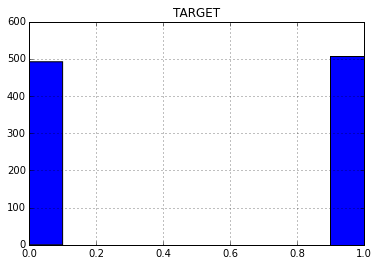

In [18]:
# pour visualiser le fait qu'ils aient le meme nombre : 
Y.hist()

# Représentation de quelques variables

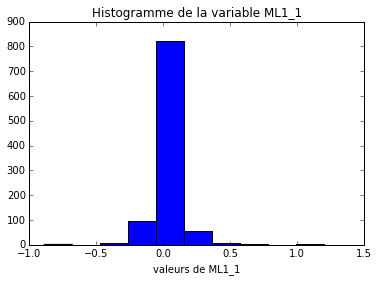

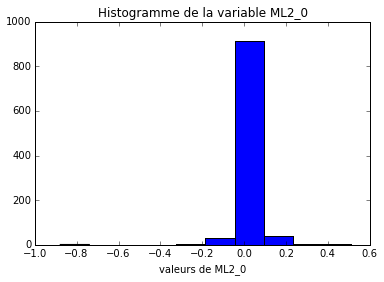

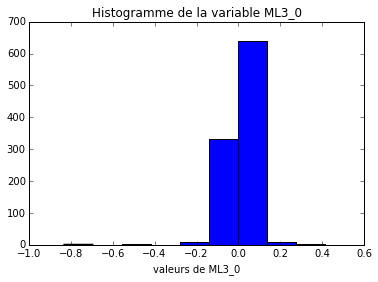

In [13]:
plt.hist(Xtrain["ML1_1"])
plt.title('Histogramme de la variable ML1_1')
plt.xlabel('valeurs de ML1_1')

plt.figure()
plt.hist(Xtrain.iloc[:,750])
plt.title('Histogramme de la variable ' + str(Xtrain.columns[750]))
plt.xlabel('valeurs de ' + str(Xtrain.columns[750]))

plt.figure()
plt.hist(Xtrain.iloc[:,2*750])
plt.title('Histogramme de la variable ' + str(Xtrain.columns[2*750]))
plt.xlabel('valeurs de ' + str(Xtrain.columns[2*750]))

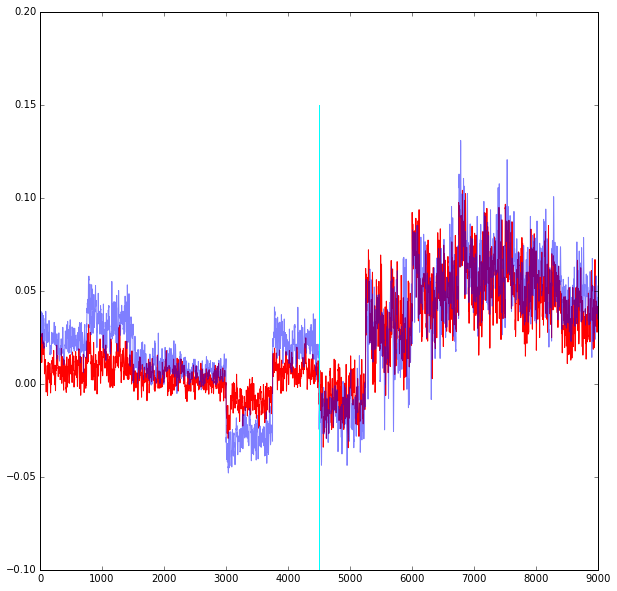

In [16]:
plt.figure(figsize=(10,10))
#ax = plt.plot(np.array(Xtrain).mean(axis=0))
plt.plot(np.array(inverted).mean(axis=0), color= 'red')          # on a effectue la moyenne sur les lignes donc on a la  moyenne de chaque colonne
plt.plot(np.array(no_inverted).mean(axis=0), color= 'blue',alpha=0.5)
plt.plot((4500,4500),(-0.10,0.15),'cyan')    # tracer de la droite verticale

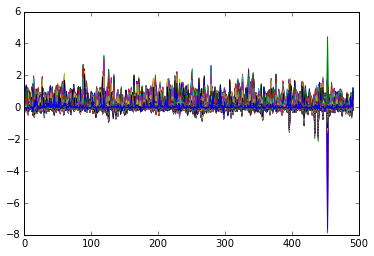

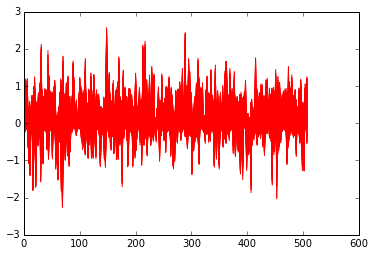

In [29]:
plt.figure()
plt.plot(no_inverted.values[:,750:1500])     # correspondant a un 1 dans le tableau des Y

plt.figure()
plt.plot(inverted.values[:,750:1500], color='red')     # correspondant a un 0 dans le tableau des Y
show()

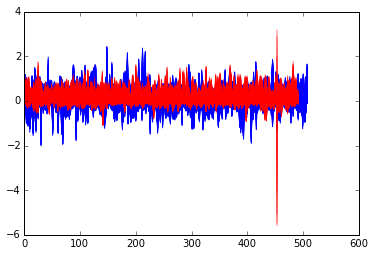

In [28]:
plt.figure()
plt.plot(Xtrain.iloc[:,:750][Y["TARGET"]==1], color="blue")
plt.plot(Xtrain.iloc[:,:750][Y["TARGET"]==0], color="red", alpha=0.5)
show()

#### si on voulait extraire les trois premiers maximum ou minimum de chaque channel, on peut trier le dataframe Xtrain et récupérer les trois premieres valeurs qui correspondent aux trois maximum donc à trois pics. On peut faire la même chose en prenant les trois plus petites valeurs, les trois minimum, du tableau. Attention cela dit pour la récupération on doit d'abord split le tableau en 12 toutes les 750 colonnes pour ne pas mélanger toutes les valeurset les variables. On peut recréer le tableau pas la suite à l'aide de la fonction concatenate. 

In [ ]:
# split le tableau en 12 avec boucle for et range(12)
# trier chaque tableau en bouclant les np.sort() appliqué à chacun de ces sous tableaux

# Plus simple: faire le sort() directement sur une copie de Xtrain en appliquant, grace à une boucle, le tri par paquet
# de 750 colonnes
# copie: Xcopy = Xtrain.copy() 
# for i in range(12):
    #np.sort(np.array(Xtrain)[:,i*750:i*750+750])

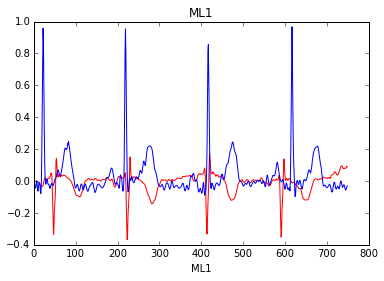

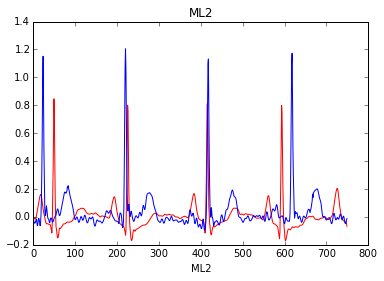

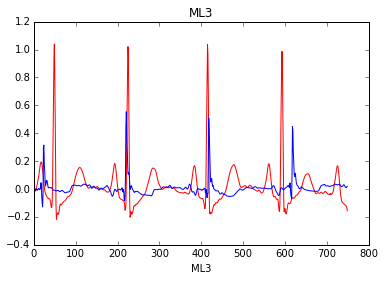

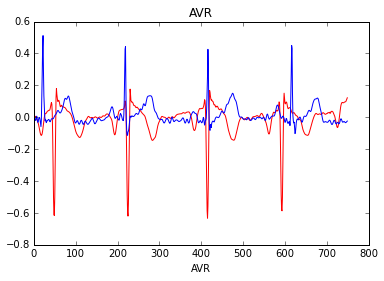

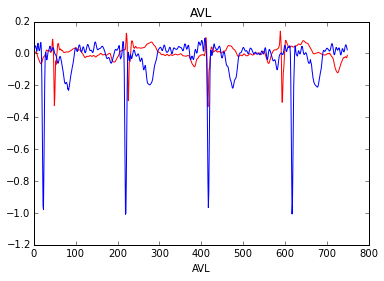

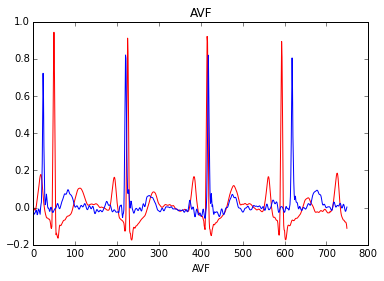

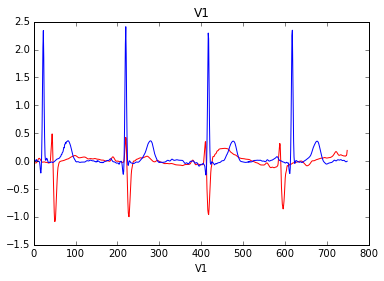

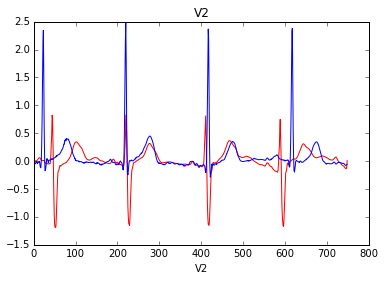

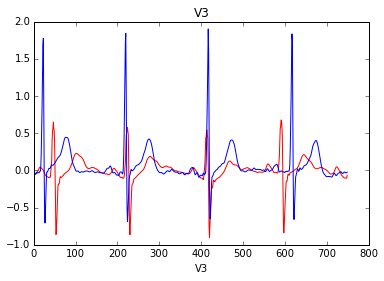

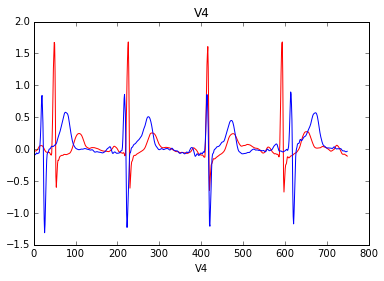

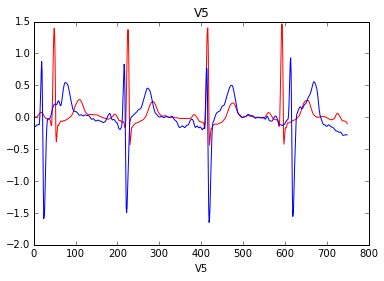

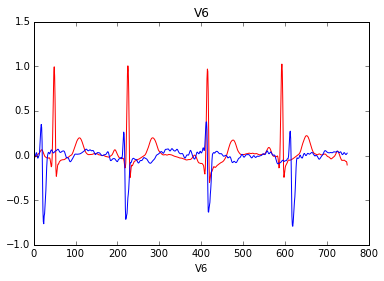

In [22]:
for i in range(12):
    plt.figure()
    plt.plot(Xtrain.iloc[8,i*750:i*750 + 750], color='red') 
    plt.plot(Xtrain.iloc[9,i*750:i*750 + 750]) 
    plt.title(Xtrain.columns[i*750].replace("_0",""))
    plt.xlabel(Xtrain.columns[i*750].replace("_0",""))

### En traçant pour un seul signal:

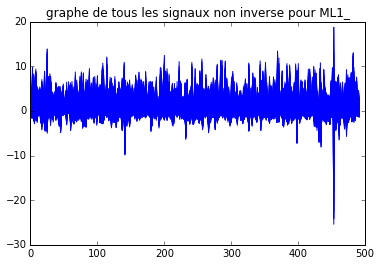

In [79]:
plt.figure()
plt.plot(no_inverted.iloc[:,0:750],color='blue')
plt.title("graphe de tous les signaux non inverse pour ML1_")
show()

# Histogrammes du data frame nwtab

#### On crée le tableau

In [28]:
# Pour crée le tableau nwtab contenant toutes les moyennes ecart-type etc
def create_tab(data, place = 0, f = None):
    array = np.array(data[data.columns[place*750:place*750+750]])
    return f(array, axis = 1)

In [24]:
nwtab = pd.DataFrame()

In [29]:
def add(data_train):
    Xtrain = data_train
    for i in range (12):
        Xtrain[Xtrain.columns[i*750].replace("_0","") + "_std"] = create_tab (Xtrain, place = i, f = np.std)

    for i in range (12):    
        Xtrain[Xtrain.columns[i*750].replace("_0","") + "_mean"] = create_tab (Xtrain, place = i, f = np.mean)

    for i in range (12):
        Xtrain[Xtrain.columns[i*750].replace("_0","") + "_min"] = create_tab (Xtrain, place = i, f = np.min)

    for i in range (12):
        Xtrain[Xtrain.columns[i*750].replace("_0","") + "_max"] = create_tab (Xtrain, place = i, f = np.max)
    return Xtrain

In [61]:
Y.head(10)

,TARGET
ID,
0,1
1,1
2,1
3,1
4,0
5,1
6,0
7,0
8,1


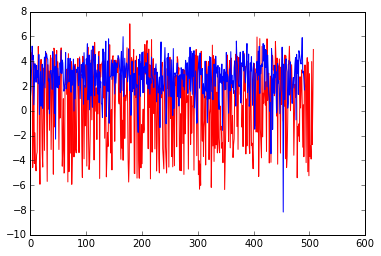

In [85]:
plt.figure()
plt.plot(inverted.iloc[:,:750].skew(axis=1), color='red')   # skew calcul l'asymetrie de l'echantillon de valeur (3eme moment)
plt.plot(no_inverted.iloc[:,:750].skew(axis=1),color='blue')    

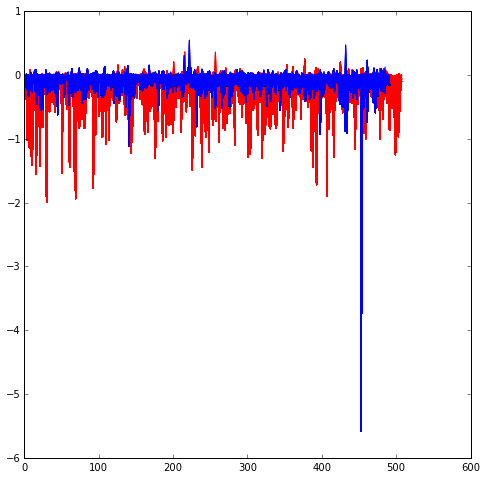

In [27]:
plt.figure(figsize=(8,8))
plt.plot(inverted.iloc[:,:750].cummin(axis=1), color='red')
plt.plot(no_inverted.iloc[:,:750].cummin(axis=1),color='blue') 
show()

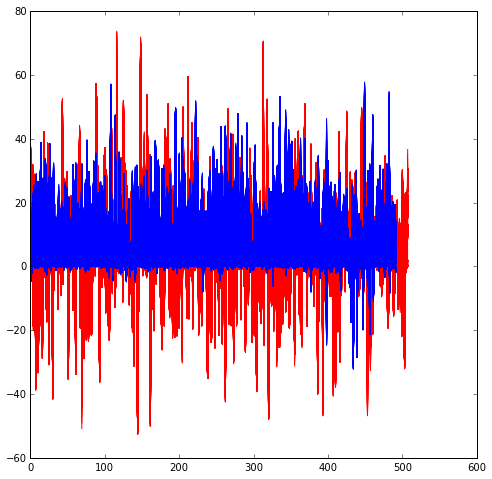

In [26]:
plt.figure(figsize=(8,8))
plt.plot(inverted.iloc[:,:750].cumsum(axis=1), color='red')
plt.plot(no_inverted.iloc[:,:750].cumsum(axis=1),color='blue')
show()

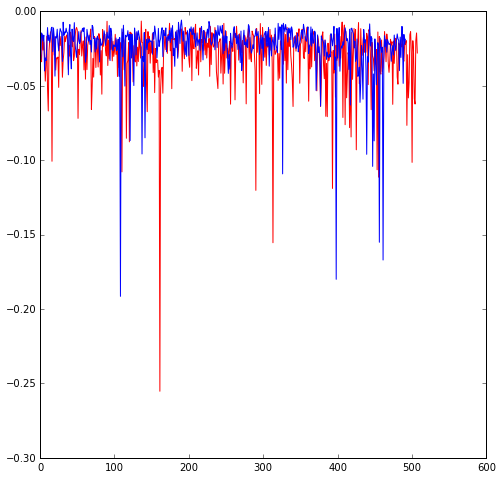

In [96]:
plt.figure(figsize=(8,8))
plt.plot(inverted.iloc[:,:750].quantile(0.25,axis=1), color='red')
plt.plot(no_inverted.iloc[:,:750].quantile(0.25,axis=1),color='blue')

In [26]:
nwtab.head()

,ML1_mean,ML2_mean,ML3_mean,AVR_mean,AVL_mean,AVF_mean,V1_mean,V2_mean,V3_mean,V4_mean,...,ML3_max,AVR_max,AVL_max,AVF_max,V1_max,V2_max,V3_max,V4_max,V5_max,V6_max
0,0.051384,0.055794,0.004410,0.023487,-0.053589,0.030102,0.024660,0.244894,0.228993,0.119946,...,0.079131,1.005063,0.469453,1.058765,1.338781,2.851282,2.562940,1.664624,2.115454,1.047272
1,0.017073,0.018583,0.001510,0.007781,-0.017828,0.010047,-0.016321,0.001502,0.018291,0.027260,...,0.051852,0.541072,0.274101,0.550672,0.194544,0.577712,0.778623,1.208903,0.969648,0.650342
2,0.035289,0.016507,-0.018782,0.027035,-0.025898,-0.001137,-0.000584,0.039743,0.078486,0.068787,...,0.250529,1.017967,0.168451,0.192017,0.376519,0.831064,1.668849,1.997700,1.556707,1.017472
3,0.042766,0.050507,0.007742,0.017512,-0.046636,0.029125,-0.011057,0.075199,0.091094,0.126807,...,0.129454,0.466425,0.044804,0.653563,0.201498,1.067744,1.274010,1.903447,1.922478,1.502626
4,0.015457,0.055998,0.040541,-0.012542,-0.035728,0.048269,0.000237,0.055500,0.113962,0.097330,...,1.346433,0.151690,0.134841,1.362431,0.454183,0.755442,0.955803,1.621165,1.228593,1.010478


### séparation des données en inversé et non inversé dans nwtab :

In [26]:
# Séparation des données en inverse et non inverse : 
inverted_nwtab = pd.DataFrame(np.array(nwtab)[np.where(Y["TARGET"]==1)])
no_inverted_nwtab = pd.DataFrame(np.array(nwtab)[np.where(Y["TARGET"]==0)])

### Pour les moyennes : 

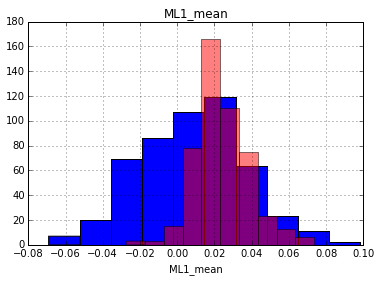

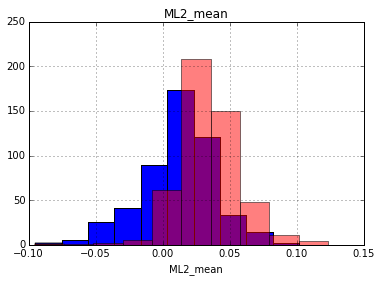

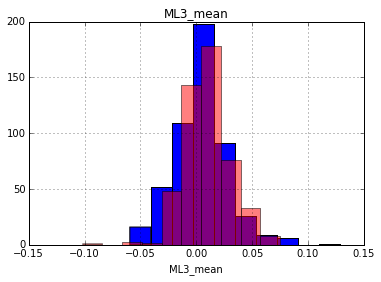

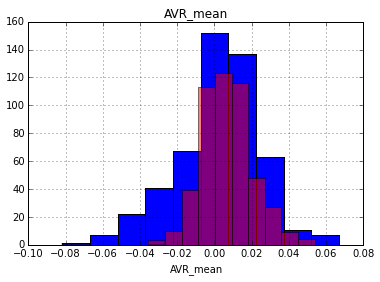

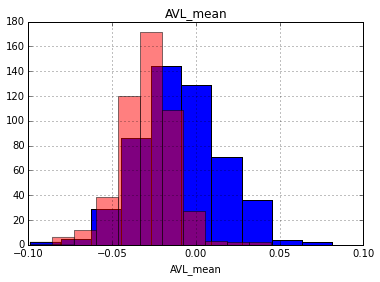

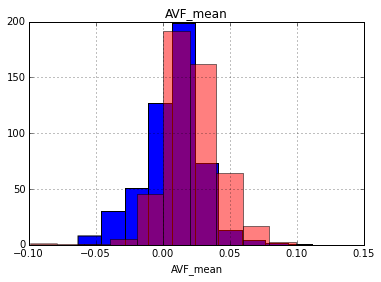

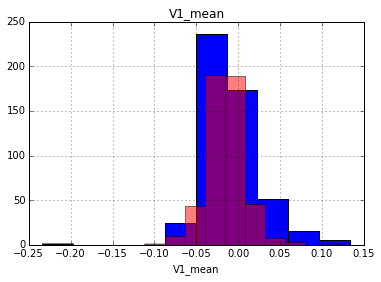

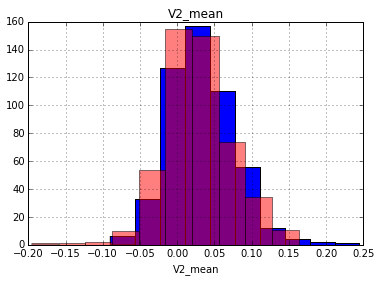

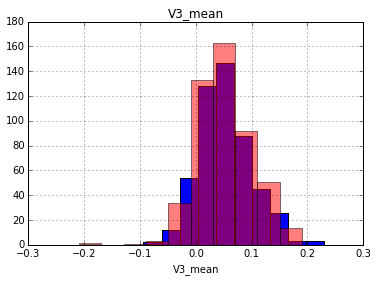

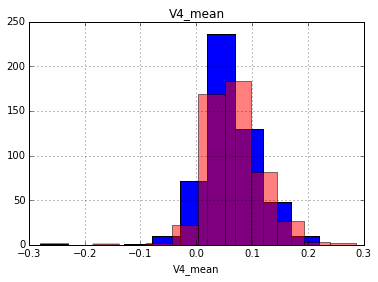

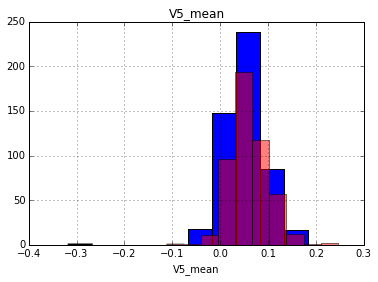

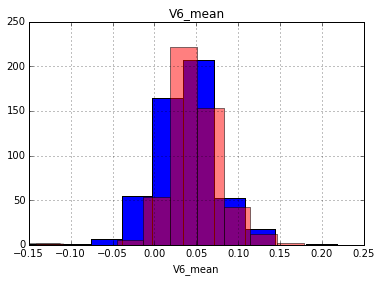

In [28]:
# Pour les moyennes:
# Construction des histogrammes
for channel in inverted_nwtab.columns[range(12)]:
    plt.figure()
    ax = inverted_nwtab[channel].hist(color = "blue")
    plt.title(nwtab.columns[channel])
    plt.xlabel(nwtab.columns[channel])
    ax = no_inverted_nwtab[channel].hist(color = "red", alpha = 0.5, ax = ax)
    plt.show()

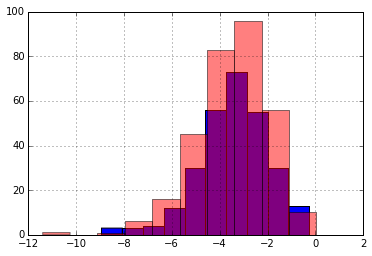

In [32]:
plt.figure()
ax = (log(inverted[11])).hist(color = "blue")
ax = (log(no_inverted[11])).hist(color = "red", alpha = 0.5, ax = ax)

### Pour les min et les max : 

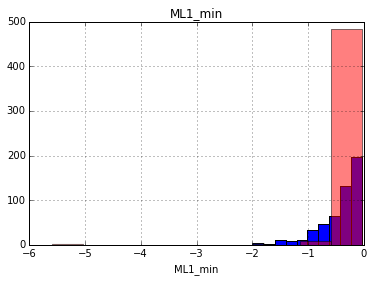

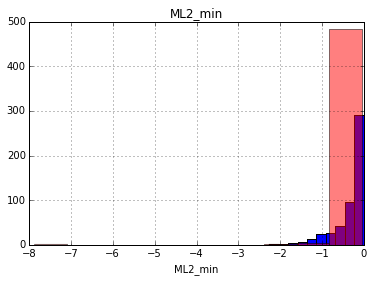

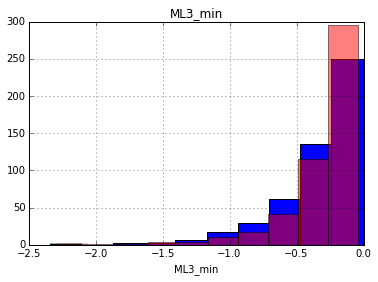

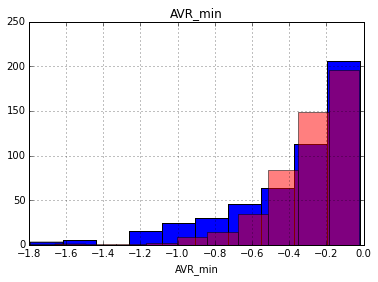

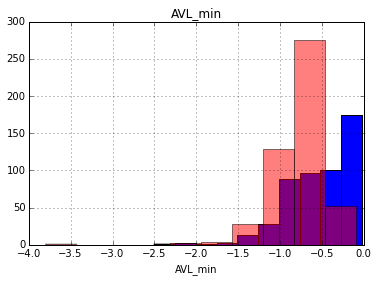

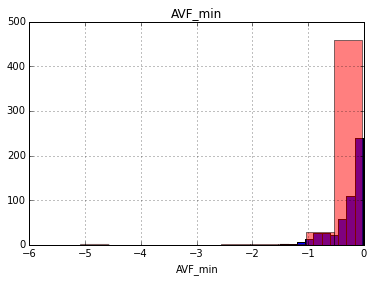

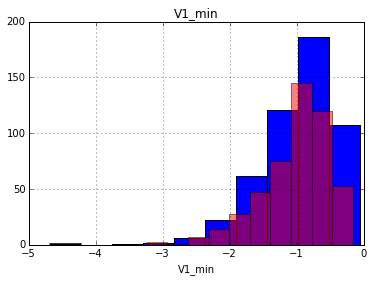

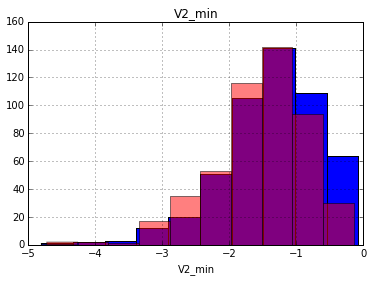

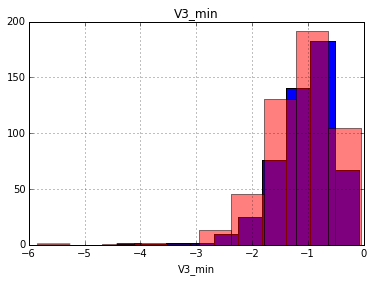

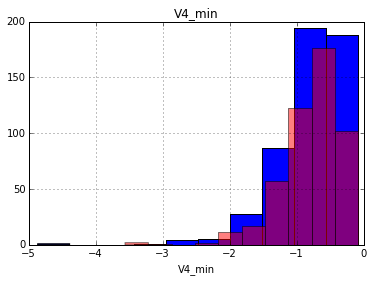

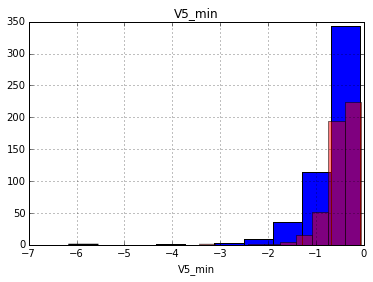

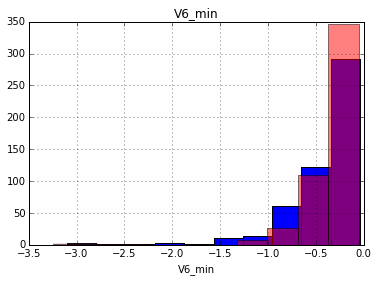

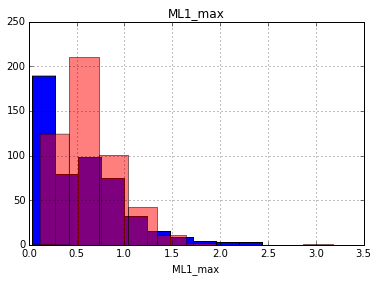

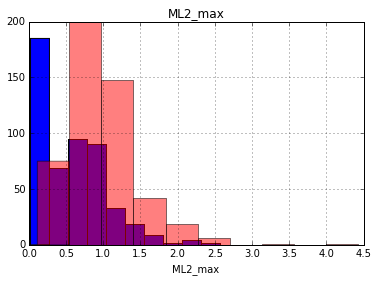

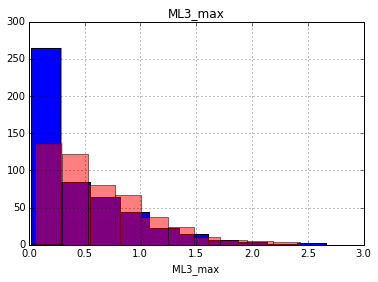

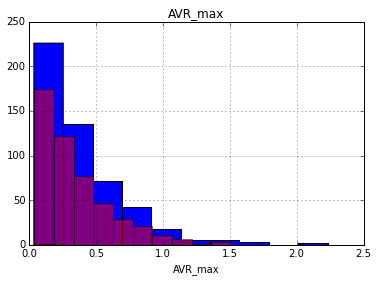

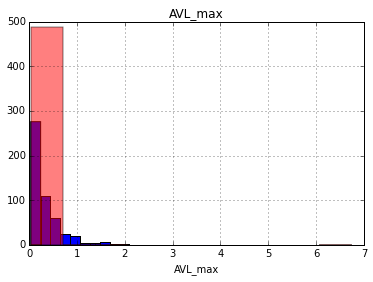

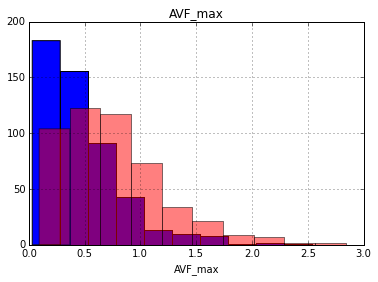

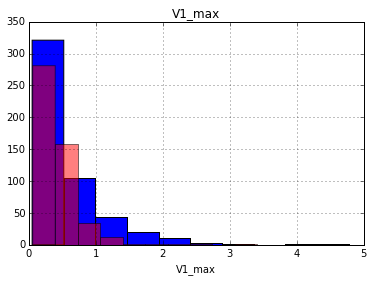

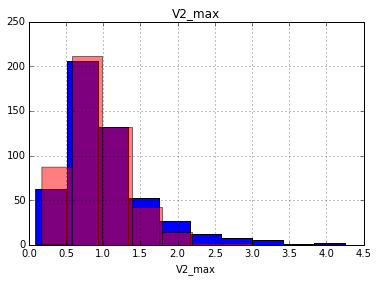

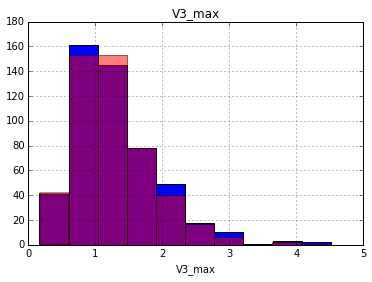

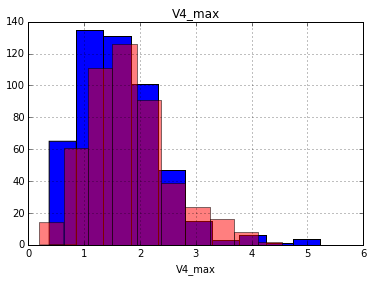

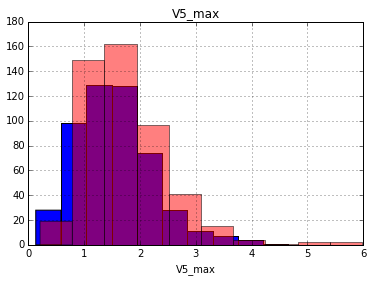

In [29]:
# Construction des histogrammes
for channel in inverted_nwtab.columns[range(-24,-1)]:
    plt.figure()
    ax = inverted_nwtab[channel].hist(color = "blue")
    plt.title(nwtab.columns[channel])
    plt.xlabel(nwtab.columns[channel])
    ax = no_inverted_nwtab[channel].hist(color = "red", alpha = 0.5, ax = ax)
    plt.show()

On remarque une grosse différence sur les 6 premiers channels au niveau de la moyenne contrairement aux 6 derniers

In [141]:
inverted_nwtab.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
           dtype='int64')

In [ ]:
nwtab.shape

## *** ------------------------------------------------------------------------------ ***

### corrélation sur les moyennes des variables de nwtab

In [31]:
C = nwtab[range(12)].corr()
C;

<matplotlib.colorbar.Colorbar instance at 0x10afcd3f8>

/Users/francoisczarny/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


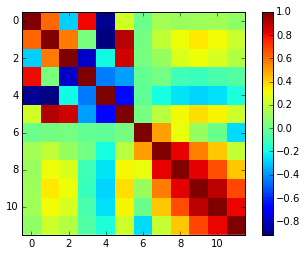

In [32]:
plt.imshow(C, interpolation='none')
plt.colorbar()

# ACP sur l'ensemble de Xtrain

### Sans renormalisation des données : 

In [64]:
pca = PCA(n_components = 600)
pca.fit(Xtrain)
data_pca = pca.transform(Xtrain) 

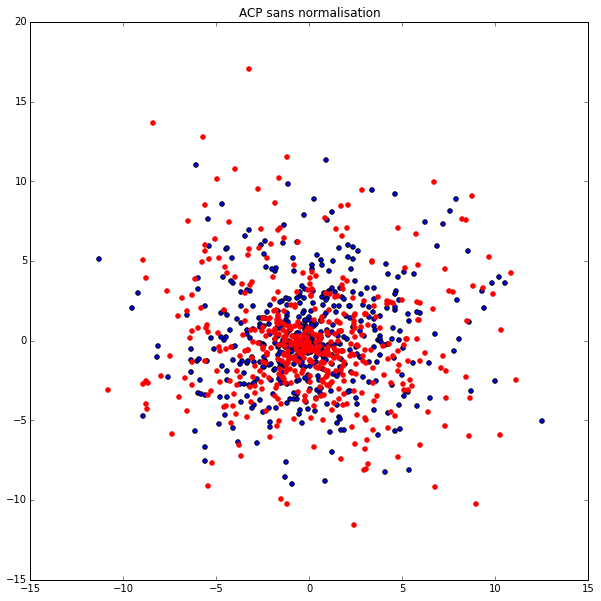

In [65]:
plt.figure(figsize=(10,10))   # explicite à python le fait qu'on va faire une nouvelle figure
inverted = pd.DataFrame(np.array(Xtrain)[np.where(Y["TARGET"]==1)])
no_inverted = pd.DataFrame(np.array(Xtrain)[np.where(Y["TARGET"]==0)])

inverted_pca = pca.transform(inverted)
no_inverted_pca = pca.transform(no_inverted)

plt.scatter(inverted_pca[:,0], inverted_pca[:,1])
plt.scatter(no_inverted_pca[:,0], no_inverted_pca[:,1], color = 'red')
plt.title("ACP sans normalisation")

### Normalisation des données, ACP Normée :

On normalise à présent les données du tableau, pour affecter la meme importance à toutes les variables explicatives, y compris celle ayant au départ une variance importante (donc qui peuvent eventuellement avoir une grosse influence sur les prédictions) (cf doc. scikit sur preprocessing.scale)

In [66]:
Xtrain_norm = preprocessing.scale(Xtrain)

On effectue à présent une ACP normée sur les données:

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 600)
pca.fit(Xtrain_norm)
data_pca = pca.transform(Xtrain_norm)  # récupération de la matrice des composantes principales de l'ACP
pca.explained_variance_ratio_;      

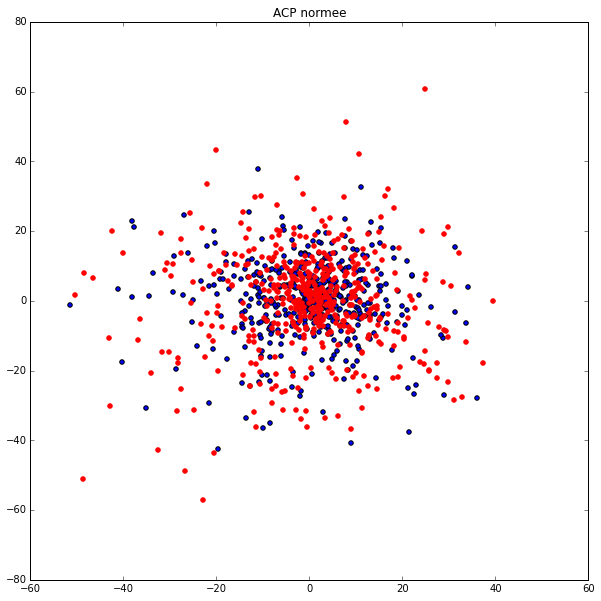

In [73]:
plt.figure(figsize=(10,10)) 
inverted = pd.DataFrame(np.array(Xtrain_norm)[np.where(Y["TARGET"]==1)])
no_inverted = pd.DataFrame(np.array(Xtrain_norm)[np.where(Y["TARGET"]==0)])
inverted_pca = pca.transform(inverted)
no_inverted_pca = pca.transform(no_inverted)

plt.scatter(inverted_pca[:,0], inverted_pca[:,1])
plt.scatter(no_inverted_pca[:,0], no_inverted_pca[:,1], color = 'red')
plt.title("ACP normee")

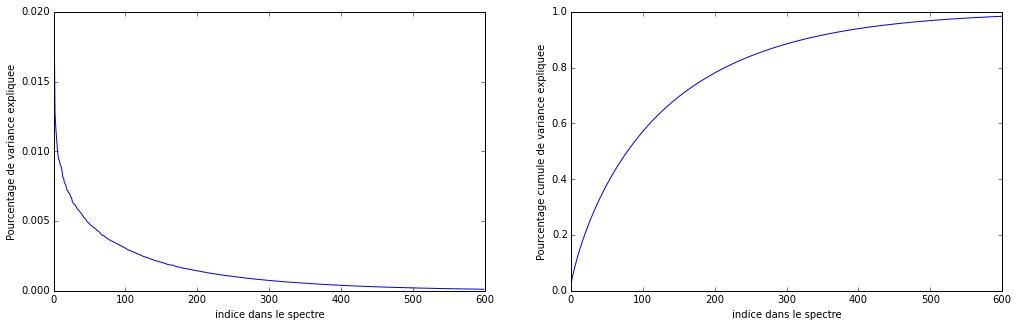

In [74]:
fig = plt.figure(figsize = (17,5))
ax = fig.add_subplot(121)
ax.plot(range(pca.explained_variance_ratio_.shape[0]), pca.explained_variance_ratio_)  # range de la dimension à expliqué
# et shape[0] est le nombre de composant contenu dans le pca...
ax.set_ylabel('Pourcentage de variance expliquee')
ax.set_xlabel('indice dans le spectre')
ax = fig.add_subplot(122)
ax.plot(range(pca.explained_variance_ratio_.shape[0]), pca.explained_variance_ratio_.cumsum())
ax.set_ylabel('Pourcentage cumule de variance expliquee')
ax.set_xlabel('indice dans le spectre')

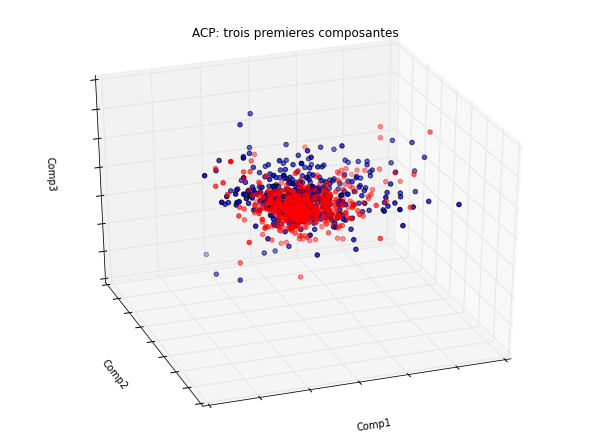

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(inverted_pca[:, 0], inverted_pca[:, 1], inverted_pca[:, 2], cmap=plt.cm.Paired, color='red')
ax.scatter(no_inverted_pca[:, 0], no_inverted_pca[:, 1], no_inverted_pca[:, 2], cmap=plt.cm.Paired)
ax.set_title("ACP: trois premieres composantes")
ax.set_xlabel("Comp1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Comp2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Comp3")
ax.w_zaxis.set_ticklabels([])
show()

# Interpreter les deux graphiques précedents par rapport à l'info expliqué 

# K-means ++

In [61]:
Xtrain_transpose = Xtrain.T

In [ ]:
Xtrain_transpose.shape

In [ ]:
from sklearn.cluster import KMeans
Xtrain_t_KMeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300)
Xtrain_t_KMeans.fit(Xtrain_transpose)

In [ ]:
nvDF = pd.DataFrame()
nvDF["y"] = np.array(Xtrain[Xtrain.columns[np.where(Xtrain_t_KMeans.labels_ == 0)[0]]]).mean(axis=1)
nvDF["x"] = np.array(Xtrain[Xtrain.columns[np.where(Xtrain_t_KMeans.labels_ == 1)[0]]]).mean(axis=1)
 

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111)
for i in range(2):
    if i == 1:
        c="blue"
    else : 
        c="red"
    ax.scatter(np.array(nvDF)[np.where(Y["TARGET"]==i)[0],0],np.array(nvDF)[np.where(Y["TARGET"]==i)[0],1], c=c, alpha=0.5)
ax.legend()
plt.title("K-Means")
show()

#### pour augmenter la significativité de la validation, nous utiliserons la moyenne de plusieurs validations croisées, disons cinq

Le fait de faire un histogramme, donne l'impression d'une répartition d'une loi normale. Cela pourrait nous dirigé plus tard pour le choix d'un noyau gaussien pour la variable ML1, par exemple si on teste une technique à noyau du type K-PCA. 
On peut essayé de séparer le tableau des Y avec ceux égaux à 1 et ceux égaux à 0 pour voir si certaines tendances ressortent peut-etre.
On peut aussi voir, grace à cela l'intervalle sur lesquel la variable évolue. Bien qu'il puisse etre aussi simple de chercher le min max. L'histogramme etant un estimateur de la densité (cf. nonparametric and semiparametric models, W.Hardle, M.Muller, S.Sperlich, Springer)

# K-PCA

In [96]:
kpca = KernelPCA(n_components=100, kernel="rbf")
X_kpca = kpca.fit_transform(Xtrain_norm)         # renvoie la matrice des points calculé par le kpca dans le nouvel
                                                 # espace
Xkpca0 = X_kpca[:,0]
Xkpca1 = X_kpca[:,1]
ind = [np.where(Y["TARGET"] == 1)[0], np.where(Y["TARGET"] == 0)[0]]

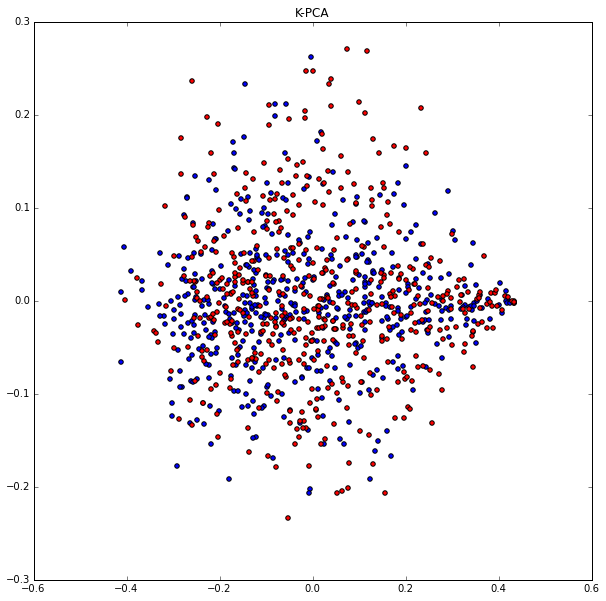

In [97]:
fig = plt.figure(figsize = (10,10))      # On définit la taille de la figure
ax = fig.add_subplot(111)                
for i in range(2):
    if i == 0:
        c="blue"
    else : 
        c="red"    
    plt.scatter(Xkpca0[ind[i]], Xkpca1[ind[i]], c=c )
plt.title("K-PCA")
show()

# ISOMAP

In [91]:
from sklearn import manifold
iso_digits3 = manifold.Isomap(5, n_components=2).fit_transform(Xtrain)
iso_Comp0 = iso_digits3[:,0]
iso_Comp1 = iso_digits3[:,1]
ind = [np.where(Y["TARGET"] == 1)[0], np.where(Y["TARGET"] == 0)[0]]

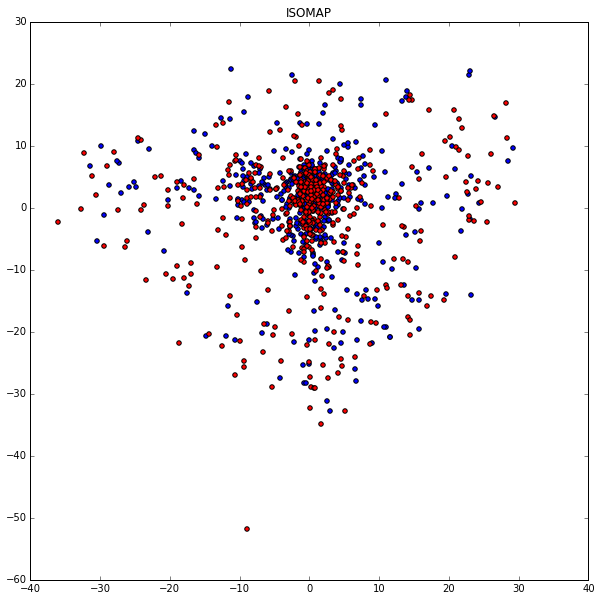

In [92]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
for i in range(2):
    if i == 0:
        c="blue"
    else : 
        c="red"  
    plt.scatter(iso_Comp0[ind[i]], iso_Comp1[ind[i]], c=c)
plt.title("ISOMAP")    
show()

Verdict : Toujours aussi mauvais

### On introduit la fonction pour pouvoir calculer le score : 

In [50]:
import sklearn.cross_validation as cv

def compute_score(clf, Xtrain, Y):
      xval = cv.cross_val_score(clf, Xtrain, Y, cv = 5)
      return xval.mean(), xval.std()

Cette fonction prend en paramètre un classifieur, la matrice "Xtrain" et la cible "Y". Elle fait appel au module cross_val_score qui réalise 5 validations croisées, c’est-à-dire qu’on entraîne sur 4/5 du jeu de données et qu’on teste sur le 1/5 restant.

# gridsearch

In [73]:
def grid_search(data, y, n=[], estimator = None):
        score = []
        for i in range(len(n)):
            print str(i) + ":testing for " + str(n[i])
            KPCA = KernelPCA(n_components = n[i], kernel="rbf")
            X_fit = KPCA.fit_transform(data)  
            score.append(compute_score(estimator, X_fit, y)[0])
        return np.array(score)

In [98]:
from sklearn.ensemble import RandomForestClassifier
n=[150,200,225,250,275,300]
score = grid_search(Xtrain, Y["TARGET"], n= n , estimator = RandomForestClassifier(n_estimators=300))


0:testing for 150
1:testing for 200
2:testing for 225
3:testing for 250
4:testing for 275
5:testing for 300
6:testing for 400


[ 0.63201778  0.64694295  0.64096782  0.6449528   0.66491832  0.64600783
  0.65684335]


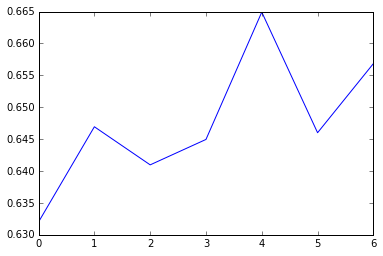

In [99]:
print(score)
plt.figure()
plt.plot(range(len(n)),score)

0:testing for 200
1:testing for 245
2:testing for 250
3:testing for 255
4:testing for 300
[ 0.63994777  0.63793752  0.6689934   0.66490832  0.6439228 ]


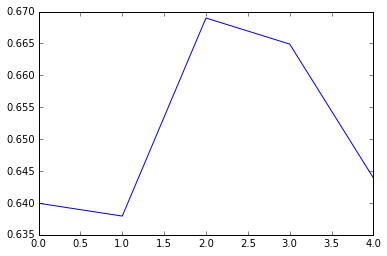

In [97]:
def grid_search(data, y, n=[], estimator = None):
        score = []
        for i in range(len(n)):
            print str(i) + ":testing for " + str(n[i])
            PPCA = PCA(n_components = n[i])
            X_fit = PPCA.fit_transform(data)  
            score.append(compute_score(estimator, X_fit, y)[0])
        return np.array(score)
    
from sklearn.ensemble import RandomForestClassifier
n=[200,245,250,255,300]
score = grid_search(Xtrain, Y["TARGET"], n= n , estimator = RandomForestClassifier(n_estimators=300))    

print(score)
plt.figure()
plt.plot(range(len(n)),score)

### Afin d'améliorer l'ensemble des données d'apprentissage on y ajoute de nouvelles variables

In [31]:
for i in range (12):
    Xtrain[Xtrain.columns[i*750].replace("_0","") + "_mean"] = create_tab (Xtrain, place = i, f = np.mean)
for i in range(12):
    Xtrain[Xtrain.columns[i*750].replace("_0","") + "_std"] = create_tab (Xtrain, place = i, f = np.std)
for i in range(12):  
    Xtrain[Xtrain.columns[i*750].replace("_0","") + "_min"] = create_tab (Xtrain, place = i, f = np.min)
for i in range(12):
    Xtrain[Xtrain.columns[i*750].replace("_0","") + "_max"] = create_tab (Xtrain, place = i, f = np.max)

In [32]:
print Xtrain.shape # on vérifie qu'on a bien ajouter des colonnes
Xtrain.head()

(1000, 9048)


,ML1_0,ML1_1,ML1_2,ML1_3,ML1_4,ML1_5,ML1_6,ML1_7,ML1_8,ML1_9,...,ML3_max,AVR_max,AVL_max,AVF_max,V1_max,V2_max,V3_max,V4_max,V5_max,V6_max
ID,,,,,,,,,,,,,,,,,,,,,
0,0.021276,0.039363,-0.001475,0.023994,0.009620,0.036350,0.028983,0.031416,0.030435,0.023499,...,0.079131,1.005063,0.469453,1.058765,1.338781,2.851282,2.562940,1.664624,2.115454,1.047272
1,0.018403,0.026159,0.009684,0.001014,-0.000866,0.002019,0.000617,-0.011167,-0.026314,-0.026881,...,0.051852,0.541072,0.274101,0.550672,0.194544,0.577712,0.778623,1.208903,0.969648,0.650342
2,-0.020974,-0.044294,-0.044097,-0.042136,-0.041125,-0.034392,-0.033026,-0.031817,-0.032347,-0.034317,...,0.250529,1.017967,0.168451,0.192017,0.376519,0.831064,1.668849,1.997700,1.556707,1.017472
3,-0.004381,-0.017433,-0.021386,-0.020316,-0.019849,-0.023615,-0.013923,0.014080,0.088580,0.149973,...,0.129454,0.466425,0.044804,0.653563,0.201498,1.067744,1.274010,1.903447,1.922478,1.502626
4,0.022106,0.065815,0.060662,0.063035,0.065413,0.064131,0.061383,0.059843,0.060229,0.061751,...,1.346433,0.151690,0.134841,1.362431,0.454183,0.755442,0.955803,1.621165,1.228593,1.010478


In [24]:
Xtrain_norm = preprocessing.scale(Xtrain)

# Selection de variable via la fonction randomforestclassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()            # rf: variable qui va contenir une instance de l'objet, peut prendre l'argument n_estimator
rf.fit(np.array(Xtrain), Y)              # fit apprend, construit le modèle, prend les x en entrée et y en sortie.
f = rf.feature_importances_
fi = np.where(f>0)                       # on garde les variables utilisées/garder par le RFclassifier
print fi[0].shape
data_rf = Xtrain[Xtrain.columns[fi[0]]]

(753,)


/Users/francoisczarny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


On peut essayer d'afficher l'importance/poids de quelque variables dans le modèle

Feature ranking:
1. feature 1 (0.233333)
2. feature 0 (0.213641)
3. feature 2 (0.116789)
4. feature 4 (0.031441)
5. feature 9 (0.029040)
6. feature 6 (0.028615)
7. feature 13 (0.027930)
8. feature 10 (0.025993)
9. feature 3 (0.025849)
10. feature 8 (0.025796)
11. feature 17 (0.025705)
12. feature 16 (0.025492)
13. feature 11 (0.024836)
14. feature 19 (0.024758)
15. feature 7 (0.024501)
16. feature 15 (0.024489)
17. feature 12 (0.023802)
18. feature 5 (0.023450)
19. feature 14 (0.022420)
20. feature 18 (0.022118)


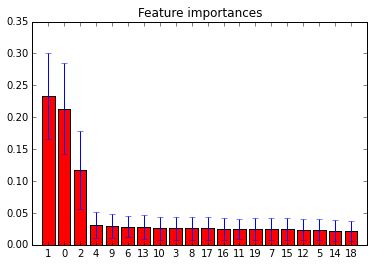

In [56]:
from sklearn.datasets import make_classification

Xtrain, Y = make_classification(n_samples=700,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

forest = RandomForestClassifier(n_estimators=400,
                              random_state=0)

forest.fit(np.array(Xtrain), Y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(Xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [75]:
# On utilise ici le modele de la regression logistique:
from sklearn.linear_model import LogisticRegression

lr_r = LogisticRegression()
train = int (np.array(data_rf).shape[0] * 0.9)
lr_r.fit(np.array(data_rf)[0:train], Y[0:train])

lr_p = LogisticRegression()
lr_p.fit(np.array(data_pca)[0:train], Y[0:train])

lr_all = LogisticRegression()
lr_all.fit(np.array(Xtrain)[0:train], Y[0:train])

print lr_r.score(np.array(data_rf)[train:], Y[train:])
print lr_p.score(np.array(data_pca)[train:], Y[train:])
print lr_all.score(np.array(Xtrain)[train:], Y[train:])

/Users/francoisczarny/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/francoisczarny/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.62
0.53
0.52


/Users/francoisczarny/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
lr_r = RandomForestClassifier(n_estimators = 300)
train = int (np.array(data_rf).shape[0] * 0.9)
lr_r.fit(np.array(d<)[0:train], Y[0:train])

lr_p = RandomForestClassifier(n_estimators = 300)
lr_p.fit(np.array(data_pca)[0:train], Y[0:train])

lr_all = RandomForestClassifier(n_estimators = 300)
lr_all.fit(np.array(Xtrain)[0:train], Y[0:train])

print lr_r.score(np.array(data_rf)[train:], Y[train:])
print lr_p.score(np.array(data_pca)[train:], Y[train:])
print lr_all.score(np.array(Xtrain)[train:], Y[train:])

/Users/francoisczarny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/Users/francoisczarny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.79
0.68
0.75


/Users/francoisczarny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [57]:
from sklearn.svm import SVC

lr_r = SVC()
train = int (np.array(data_rf).shape[0] * 0.9)
lr_r.fit(np.array(data_rf)[0:train], Y[0:train])

lr_p = SVC()
lr_p.fit(np.array(data_pca)[0:train], Y[0:train])

lr_all = SVC()
lr_all.fit(np.array(Xtrain)[0:train], Y[0:train])

print lr_r.score(np.array(data_rf)[train:], Y[train:])
print lr_p.score(np.array(data_pca)[train:], Y[train:])
print lr_all.score(np.array(Xtrain)[train:], Y[train:])

/Users/francoisczarny/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:472: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)
/Users/francoisczarny/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:472: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


0.59
0.51
0.51


/Users/francoisczarny/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:472: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


# Pour une meilleure visualisation, test de plusieurs modeles

In [59]:
y = Y["TARGET"]
train = int (np.array(data_rf).shape[0] * 0.8)
y_test = np.array(Y[train:]).reshape(Y[train:].shape[0])  # On reshape car y = liste de vecteur dont y = [[1], [0]] etc et on veut y = [1,0]
y_train = np.array(Y[0:train]).reshape(Y[0:train].shape[0])

### On reprend les modeles précédents avec le nouveau tableau renormalisé :

Avec toutes les données : 

In [60]:
x_test = np.array(Xtrain_norm)[train:]
x_train = np.array(Xtrain_norm)[0:train]

On peut aussi utiliser la fonction de scikit : 

In [48]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(Xtrain, Y)
clf = RandomForestClassifier(n_estimators=300)
clf.fit(X_train, Y_train);

Avec les données renvoyées par l'ACP : 

In [61]:
x_test_pca = np.array(data_pca)[train:]
x_train_pca = np.array(data_pca)[0:train]

Avec les données renvoyées par le randomforest classifieur : 

In [62]:
x_test_rf = np.array(data_rf)[train:]
x_train_rf = np.array(data_rf)[0:train]

In [63]:
score = {}

On calcule ici sur les ensembles d'apprenstissage pour se faire une idée même si on surestime le modèle et que l'erreur comise est inférieur à l'erreur réelle.

In [64]:
from sklearn.linear_model import LogisticRegression

sc = compute_score(LogisticRegression(), x_train_rf, y_train)
score["logistic rf"] = sc[0]
sc = compute_score(LogisticRegression(), x_train_pca, y_train)
score["logistic pca"] = sc[0]
sc = compute_score(LogisticRegression(), x_train, y_train)
score["logistic"] = sc[0]

In [65]:
rf = RandomForestClassifier
sc = compute_score(rf(), x_train_rf, y_train)
score["Random Forest rf"] = sc[0]
sc = compute_score(rf(), x_train_pca, y_train)
score["Random Forest pca"] = sc[0]
sc = compute_score(rf(), x_train, y_train)
score["Random Forest"] = sc[0]

In [66]:
sc = compute_score(SVC(), x_train_rf, y_train)
score["SVM rf"] = sc[0]
sc = compute_score(SVC(), x_train_pca, y_train)
score["SVM pca"] = sc[0]
sc = compute_score(SVC(), x_train, y_train)
score["SVM"] = sc[0]

In [68]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier
sc = compute_score(dt(), x_train_rf, y_train)
score["Decision Tree rf"] = sc[0]
sc = compute_score(dt(), x_train_pca, y_train)
score["Decision Tree pca"] = sc[0]
sc = compute_score(dt(), x_train, y_train)
score["Decision Tree"] = sc[0]

In [79]:
from sklearn.ensemble import AdaBoostClassifier

ad = AdaBoostClassifier
sc = compute_score(ad(), x_train_rf, y_train)
score["AdaBoost rf"] = sc[0]
sc = compute_score(ad(), x_train_pca, y_train)
score["AdaBoost pca"] = sc[0]
sc = compute_score(ad(), x_train, y_train)
score["AdaBoost"] = sc[0]

In [83]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier
sc = compute_score(et(), x_train_rf, y_train)
score["Extra Trees rf"] = sc[0]
sc = compute_score(et(), x_train_pca, y_train)
score["Extra Trees pca"] = sc[0]
sc = compute_score(et(), x_train, y_train)
score["Extra Trees"] = sc[0]

In [87]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier
sc = compute_score(gb(), x_train_rf, y_train)
score["GradBoost rf"] = sc[0]
sc = compute_score(gb(), x_train_pca, y_train)
score["Gradboost pca"] = sc[0]
sc = compute_score(gb(), x_train, y_train)
score["Gradboost"] = sc[0]

,Extra Trees,Decision Tree pca,Gradboost,SVM rf,logistic rf,AdaBoost pca,Extra Trees rf,SVM pca,Extra Tree,Decision Tree,...,SVM,AdaBoost rf,Extra Trees pca,Extra Tree rf,Gradboost pca,Random Forest pca,GradBoost rf,logistic pca,AdaBoost,logistic
0,0.863816,0.573792,0.861339,0.697568,0.727593,0.623754,0.865113,0.51125,0.697639,0.761227,...,0.726234,0.836237,0.676209,0.740062,0.672482,0.570104,0.863863,0.646153,0.840144,0.669935


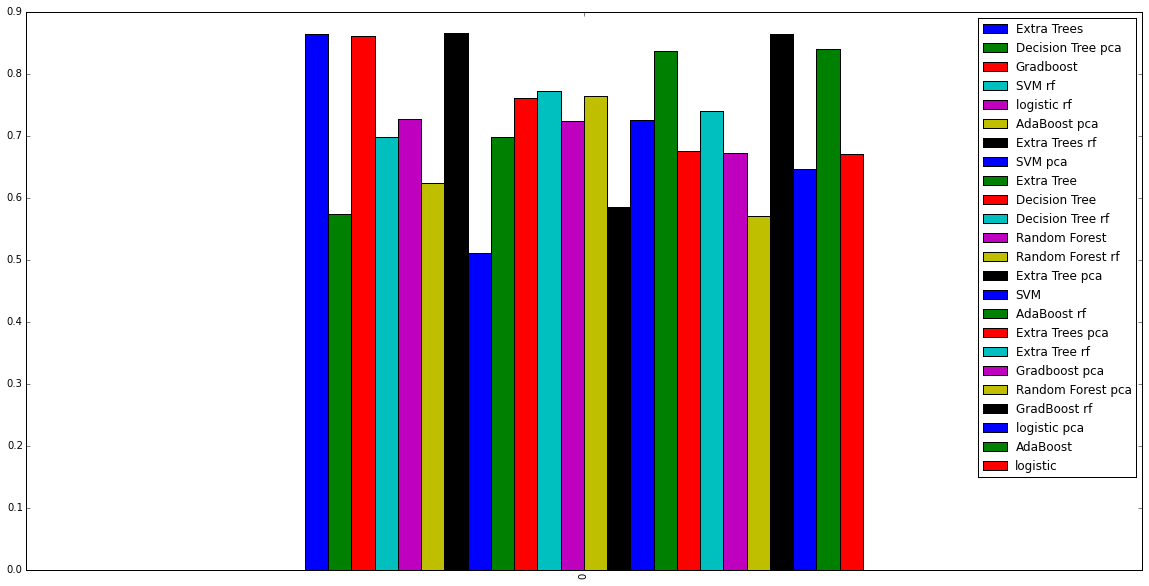

In [88]:
score_df = pd.DataFrame (np.array(score.values()).reshape(1, len(score.values())), columns = score.keys())
score_df.plot(kind = "bar", figsize = (20,10))
score_df.head()

In [73]:
from sklearn.grid_search import GridSearchCV

parameters = {'n_estimators': (10,20,30,50,100,150,200,250,270,280,290,300,310,320,330,340,350,400,450,500,600), 'bootstrap': (True, False)}
gs = GridSearchCV(RandomForestClassifier(), parameters)
fit = gs.fit(Xtrain_norm, Y['TARGET'])

In [74]:
rf = fit.best_estimator_

In [75]:
print (rf.feature_importances_>0).sum()

8837


un peu trop de variables conservées.

# Réduction de la matrice avec les random Forests

In [215]:
rf_reduction = None
score = 0

In [228]:
rf_no_boot = RandomForestClassifier(n_estimators = 300, bootstrap = False, n_jobs = 2)
rf_boot = RandomForestClassifier(n_estimators = 300, bootstrap = True, n_jobs = 2)
rf_no_boot.fit(Xtrain_norm[:800], Y['TARGET'][:800])
rf_boot.fit(Xtrain_norm, Y['TARGET'])
rf_reduction = rf_no_boot

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Résultats en cross val et random Forest de la reduction matricielle pour une valeur d'importantce > 0.0006

In [98]:
Xtrain_norm_rf = Xtrain_norm[:, rf_no_boot.feature_importances_>0.00065]
rf = RandomForestClassifier(n_estimators = 500, bootstrap = False, n_jobs = 2)
print compute_score(rf, Xtrain_norm_rf, Y['TARGET'])
rf.fit(Xtrain_norm_rf, Y['TARGET'])

(0.86289694742368561, 0.049816291583746196)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [99]:
Xtrain_norm_rf = Xtrain_norm[:, rf_no_boot.feature_importances_>0.00065]
rf2 = RandomForestClassifier(n_estimators = 499, bootstrap = False, n_jobs = 2)
print compute_score(rf2, Xtrain_norm_rf, Y['TARGET'])
rf2.fit(Xtrain_norm_rf, Y['TARGET'])

(0.86988207205180124, 0.052669606300124225)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=499, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Résultats en cross val et extra trees classifier de la reduction matricielle pour une valeur d'importantce > 0.0006

In [101]:
from sklearn.ensemble import ExtraTreesClassifier

Xtrain_norm_rf = Xtrain_norm[:, rf_no_boot.feature_importances_>0.0006]
et = ExtraTreesClassifier(n_estimators = 1200, bootstrap = False, n_jobs = 2)
print compute_score(rf, Xtrain_norm_rf, Y['TARGET'])
et.fit(Xtrain_norm_rf, Y['TARGET'])

(0.86488197204930128, 0.055678494356341333)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Résultats en cross val avec PCA et randomForest

In [102]:
rf = RandomForestClassifier(n_estimators = 600, bootstrap = False, n_jobs = 2)
print compute_score(rf, data_pca, Y['TARGET'])
rf.fit(data_pca, Y['TARGET'])

(0.69585374634365849, 0.047208720243832492)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Recherche des hyper parametres optimaux pour pca+randomForest en gridSearch

In [103]:
def gs(params_pca, params_rf, data, y):
    score = []
    for n_components in params_pca:
        print "testing for " + str(n_components)
        pca = PCA(n_components = n_components)
        pca.fit(data)
        data_pca = pca.transform(data)
        gs_cv = GridSearchCV(RandomForestClassifier(), params_rf)
        gs_cv.fit(data_pca, y)
        score.append(gs_cv)
        print gs_cv.grid_scores_
    return score

In [104]:
parameters = {'n_estimators': (100,200,300,310,320, 330, 340, 500, 600), 'bootstrap': (True, False)}
score = gs([50, 100,200, 300 , 400, 600, 800], parameters, Xtrain_norm, Y['TARGET'])

testing for 50
[mean: 0.70000, std: 0.01543, params: {'n_estimators': 100, 'bootstrap': True}, mean: 0.69400, std: 0.01938, params: {'n_estimators': 200, 'bootstrap': True}, mean: 0.70600, std: 0.01882, params: {'n_estimators': 300, 'bootstrap': True}, mean: 0.70500, std: 0.01109, params: {'n_estimators': 310, 'bootstrap': True}, mean: 0.70100, std: 0.01296, params: {'n_estimators': 320, 'bootstrap': True}, mean: 0.69400, std: 0.01325, params: {'n_estimators': 330, 'bootstrap': True}, mean: 0.68600, std: 0.01376, params: {'n_estimators': 340, 'bootstrap': True}, mean: 0.70000, std: 0.01506, params: {'n_estimators': 500, 'bootstrap': True}, mean: 0.70300, std: 0.01883, params: {'n_estimators': 600, 'bootstrap': True}, mean: 0.68300, std: 0.01664, params: {'n_estimators': 100, 'bootstrap': False}, mean: 0.71300, std: 0.02540, params: {'n_estimators': 200, 'bootstrap': False}, mean: 0.69200, std: 0.01477, params: {'n_estimators': 300, 'bootstrap': False}, mean: 0.69500, std: 0.02733, para

#### Optimaux : 0.72 : pca = 400 : RandomForest = 600 estimateurs

In [105]:
print score[4].best_score_
rf = score[4].best_estimator_

0.727


## Recherche des hyper parametres optimaux pour RF reduction+randomForest en gridSearch

In [106]:
def gs(params_rf_red, params_rf, data, y, rf_red):
    score = []
    for n_components in params_rf_red:
        print "testing for " + str(n_components)
        d = data[:, rf_red.feature_importances_>n_components]
        gs_cv = GridSearchCV(RandomForestClassifier(), params_rf)
        gs_cv.fit(data, y)
        score.append(gs_cv)
        print gs_cv.best_estimator_
    return score

In [107]:
score_rf = gs([0.00005,0.0001,0.0005,0.00055,0.0006,0.00065,0.0007,0.0008,0.001], {'n_estimators': (100,200,300,310,320, 330, 340, 500, 600), 'bootstrap': (True, False)}, Xtrain_norm, Y['TARGET'], rf_no_boot)

testing for 5e-05
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
testing for 0.0001
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=320, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
testing for 0.0005
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fra

In [108]:
for gs in score_rf:
    print gs.best_score_

0.81
0.803
0.804
0.797
0.801
0.802
0.802
0.81
0.806


In [113]:
def gs2(params_rf_red, params_rf, data, y, rf_red):
    score = []
    for n_components in params_rf_red:
        print "testing for " + str(n_components)
        d = data[:, rf_red.feature_importances_>n_components]
        gs_cv2 = GridSearchCV(RandomForestClassifier(n_jobs=2), params_rf)
        gs_cv2.fit(data, y)
        score.append(gs_cv2)
        print gs_cv2.best_estimator_
    return score


score_rf2 = gs2([0.00005,0.0001,0.0005,0.00055,0.0006,0.00065,0.0007,0.0008,0.001], {'n_estimators': (100,200,300,310,320, 330, 340, 500, 600), 'bootstrap': (True, False)}, Xtrain_norm, Y['TARGET'], rf_no_boot)

testing for 5e-05
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
testing for 0.0001
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
testing for 0.0005
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fra

In [115]:
for gs2 in score_rf2:
    print gs2.best_score_

0.805
0.802
0.797
0.798
0.799
0.802
0.804
0.797
0.807


# Tests

In [125]:
data_test = add(Xtest)
from sklearn import preprocessing
data_test_norm = preprocessing.scale(data_test)

### Réduction par les RF

##### Réduction > 0.0006

In [234]:
rf_no_boot = rf_reduction
data_r_6 = data_test_norm[:, rf_no_boot.feature_importances_>0.0006]
print data_r_6.shape
print data_test_norm.shape

(353, 255)
(353, 9048)


/Users/francoisczarny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 9048 but corresponding boolean dimension is 255
  from ipykernel import kernelapp as app


##### Réduction > 0.00065

In [232]:
data_r_1 = data_test_norm[:, rf_no_boot.feature_importances_>0.00065]
print data_r_1.shape
print data_test_norm.shape

(353, 255)
(353, 9048)


/Users/francoisczarny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 9048 but corresponding boolean dimension is 255
  if __name__ == '__main__':


#### Réduction > 0.0001

In [233]:
data_r_1 = data_test_norm[:, rf_no_boot.feature_importances_>0.0001]
print data_r_1.shape
print data_test_norm.shape

(353, 255)
(353, 9048)


/Users/francoisczarny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 9048 but corresponding boolean dimension is 255
  if __name__ == '__main__':


### Réduction par pca

In [132]:
pca = PCA(n_components = 400)
pca.fit(data_test_norm)
data_pca = pca.transform(data_test_norm)

/Users/francoisczarny/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


### Test en RandomForest avec RF optimal

In [238]:
rf = RandomForestClassifier(n_estimators = 300, bootstrap = False)
rf.fit(Xtrain_norm[:, rf_no_boot.feature_importances_>0.00065], Y['TARGET'])
print rf.score(Xtrain_norm[:, rf_no_boot.feature_importances_>0.00065], Y['TARGET'])

1.0


In [239]:
pred = rf.predict(data_r_6)

# Exportation des predictions

In [240]:
df = pd.DataFrame()
df["TARGET"] = pred
df.set_index(data_test.index)
df.to_csv("data_r_6_1.csv")

# Test Gradientboosting

In [164]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=300).fit(Xtrain_norm, Y)
clf.score(Xtrain_norm, Y)

/Users/francoisczarny/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [172]:
data_test_grdboost = preprocessing.scale(add(Xtest))

In [173]:
pred2 = clf.predict(data_test_grdboost)

In [174]:
df2 = pd.DataFrame()
df2["TARGET"] = pred2
df2.set_index(data_test.index)
df2.to_csv("data_grad.csv")

In [183]:
sum(clf.feature_importances_>0.0007)

387

In [191]:
from sklearn.ensemble import AdaBoostClassifier

ad = AdaBoostClassifier(n_estimators = 300)
ad.fit(Xtrain_norm, Y['TARGET'])
Xtrain_norm = Xtrain_norm[:, ad.feature_importances_>0.0006]
print compute_score(ad, Xtrain_norm, Y['TARGET'])

(0.91087809695242383, 0.041431221375369698)
